# Morphology from the full boxfiltered images
1. Find the surface from scanning the average boxfiltered images
2. Locate the center of the colony, and find the maximum value of the pixel count inside the colony
3. Normalize all the z-stack images with this number
4. Obtain a percentage threshold from this
5. Find the morphology through xyz

In [1]:
# Dependencies
%matplotlib notebook

import xml.etree.ElementTree as ET
import numpy as np
import glob
import cv2
import sys
import time

import colony_iomethods as cm
import pandas as pd

from matplotlib import pyplot as plt

In [15]:
# Folder for the files
# exp_name = "EQ59_Gly_02022021"
# acq_name_data = [["EQ59_Gly_02022021_TileScan_Tp1-5", "xyzt"],
#                  ["EQ59_Gly_02022021_TileScan_Tp6-7", "xyzt"],
#                  ["EQ59_Gly_02022021_TileScan_Tp8", "xyz"],
#                  ["EQ59_Gly_02022021_TileScan_Tp9", "xyz"],
#                  ["EQ59_Gly_02022021_TileScan_Tp10", "xyz"],
#                  ["EQ59_Gly_02022021_TileScan_Tp11-24", "xyzt"],
#                  ["EQ59_Gly_02022021_TileScan_Tp25", "xyz"],
#                  ["EQ59_Gly_02022021_TileScan_Tp26", "xyz"],
#                  ["EQ59_Gly_02022021_TileScan_Tp27", "xyz"],
#                  ["EQ59_Gly_02022021_TileScan_Tp28", "xyz"],
#                  ["EQ59_Gly_02022021_TileScan_Tp29", "xyz"],
#                  ["EQ59_Gly_02022021_TileScan_Tp30-38", "xyzt"],
#                  ["EQ59_Gly_02022021_TileScan_Tp39", "xyz"]]#,
# # #               ["EQ59_Gly_02022021_TileScan_Tp40", "xyz"],
# # #               ["EQ59_Gly_02022021_TileScan_Tp41", "xyz"]]
exp_name = "EQ59_Single_Colony_TilesScan.lif"
acq_name_data = [["3dTimeScan_12h_init", "xyzt"],
                  ["3dTimeScan_17h_init_long", "xyzt"]]

acq_df = pd.DataFrame(acq_name_data, columns=["acq_name", "acq_type"])

channel_str = "ch00"

exp_folder = f"D:/Tolga/Colony Images/{exp_name}/"
metadata_folders = []
base_folders = []
image_xmls = []
for aix in range(len(acq_df)):
    acq_name = acq_df["acq_name"].values[aix]
    print("Reading %s" % (acq_name), end="        \r", flush=True)
    base_folders.append(exp_folder + f"{acq_name}/")
    
    metadata_folder = base_folders[-1] + "Metadata/"

    tree = ET.parse(metadata_folder + f"{exp_name}_{acq_name}_Properties.xml")    # xml tree of the current stage position
    root = tree.getroot()           # root of the xml tree

    image_xmls.append(root[0])

# Add the metadata and xml objects to the dataframe
acq_df["base_folder"] = base_folders
acq_df["image_xml"] = image_xmls

In [16]:
average_count_ar = []
max_count_ar = []
dim_desc_ar = []
for ix in range(len(acq_df)):
    image = acq_df["image_xml"][ix]
    acq_name = acq_df["acq_name"][ix]
    acq_type = acq_df["acq_type"][ix]
    base_folder = acq_df["base_folder"][ix]
    print("Running for '%s', using method '%s'" % (acq_name, acq_type))
    
    # merged_path = merged_folder + f"{acq_name}_t0_z000.tif"
    # Copy all .tif file into a list
    fname_list = glob.glob(base_folder+f"{channel_str}/TileScan/*.tif")
    boxfiltered_path = fname_list[0]
    if acq_type == "xyzt":
#         boxfiltered_path = base_folder + channel_str + "/Boxfiltered/" + acq_name + "_Boxfiltered_t00_z000_" + channel_str + ".tif"
        if ix == 0:
            tstr_ix = 12     # timepoint identifier index
            sstr_ix = 13     # stagepos identifier index
            zstr_ix = 14    # z-scan identifier index
        else:
            tstr_ix = 14     # timepoint identifier index
            sstr_ix = 15     # stagepos identifier index
            zstr_ix = 16    # z-scan identifier index
    elif acq_type == "xyz":
#         boxfiltered_path = base_folder + channel_str + "/Boxfiltered/" + acq_name + "_Boxfiltered_z00_" + channel_str + ".tif"
        tstr_ix = None     # timepoint identifier index
        sstr_ix = 11     # stagepos identifier index
        zstr_ix = 12    # z-scan identifier index
    else:
        print("Not yet defined!!")

    # Image dimension description
    dim_desc = cm.collectImageDim(image)
    dim_desc_ar.append(dim_desc)

    img_test = cv2.imread(boxfiltered_path)
    (height, width, layers) = img_test.shape

    print("Image shape: (h%d,w%d,l%d)" % (height, width, layers))
    

    # For each file, collect string identifierse for t,s and z
    tstr_st, sstr_st, zstr_st = set(),set(),set()

    print("Did you check the tstr_ix, sstr_ix and zstr_ix??")
    display(fname_list[0].split("_"))
    display(fname_list[0].split("_")[zstr_ix])
    
    for fname in fname_list:
        fname_splt = fname.split("_")
        if tstr_ix is not None:
            tstr_st.add(fname_splt[tstr_ix])
        if sstr_ix is not None:
            sstr_st.add(fname_splt[sstr_ix])
        if zstr_ix is not None:
            zstr_st.add(fname_splt[zstr_ix])

    # Sort the string identifiers and save as an array
    tstr_ar = np.sort(list(tstr_st))
    sstr_ar = np.sort(list(sstr_st))
    zstr_ar = np.sort(list(zstr_st))
    
    if acq_type == "xyzt":
        print("Do nothing. The rest is designed for xyzt")
    #     tstr_ar = ["t10"]
    elif acq_type == "xyz":
        tstr_ar = [None]

    # zstr_ar = ["z160"]

    # Run through all the tstr and zstr
    fname_test = fname_list[0]
    img_test = cv2.imread(fname_test, cv2.IMREAD_GRAYSCALE)
    while img_test is None:
        time.sleep(1)
        img_test = cv2.imread(fname_test, cv2.IMREAD_GRAYSCALE)
        
    height, width = img_test.shape

    # For each timepoint
    average_count = np.zeros((len(tstr_ar), len(zstr_ar)), dtype=np.double)
    max_count = np.zeros((len(tstr_ar), len(zstr_ar)), dtype=np.int64)
    for tix in range(len(tstr_ar)):
        tstr = tstr_ar[tix]
        # For each z section
        for zix in range(len(zstr_ar)):
            zstr = zstr_ar[zix]
            # File path to merge into
            if tstr is not None:
                boxfiltered_path = base_folder + channel_str + "/Boxfiltered/" + acq_name + "_" + "Boxfiltered" + "_" + tstr + "_" + zstr + "_" + channel_str + ".tif"
            else:
                boxfiltered_path = base_folder + channel_str + "/Boxfiltered/" + acq_name + "_" + "Boxfiltered" + "_" + zstr + "_" + channel_str + ".tif"

            print(boxfiltered_path, end="    \r", flush=True)

            # Read the box-filtered image
            filtered = cv2.imread(boxfiltered_path, cv2.IMREAD_GRAYSCALE)

            # Collect the average values at each 50x50 corner for finding the surface
    #         average_count_ar[zix] = np.mean(filtered[:50,:50] +
    #                                 filtered[:50,-50:] +
    #                                 filtered[-50:,-50:] +
    #                                 filtered[-50:, :50])/4
            average_count[tix, zix] = np.mean(filtered)
            max_count[tix, zix] = np.max(filtered)
            
    average_count_ar.append(average_count.copy())
    max_count_ar.append(max_count.copy())

Running for '3dTimeScan_12h_init', using method 'xyzt'
Image shape: (h1024,w1024,l3)
Did you check the tstr_ix, sstr_ix and zstr_ix??


['D:/Tolga/Colony Images/EQ59',
 'Single',
 'Colony',
 'TilesScan.lif/3dTimeScan',
 '12h',
 'init/ch00/TileScan\\EQ59',
 'Single',
 'Colony',
 'TilesScan.lif',
 '3dTimeScan',
 '12h',
 'init',
 't0',
 's00',
 'z000',
 'ch00.tif']

'z000'

Do nothing. The rest is designed for xyzt
Running for '3dTimeScan_17h_init_long', using method 'xyzt'imeScan_12h_init/ch00/Boxfiltered/3dTimeScan_12h_init_Boxfiltered_t8_z167_ch00.tif    
Image shape: (h1024,w1024,l3)
Did you check the tstr_ix, sstr_ix and zstr_ix??


['D:/Tolga/Colony Images/EQ59',
 'Single',
 'Colony',
 'TilesScan.lif/3dTimeScan',
 '17h',
 'init',
 'long/ch00/TileScan\\EQ59',
 'Single',
 'Colony',
 'TilesScan.lif',
 '3dTimeScan',
 '17h',
 'init',
 'long',
 't00',
 's00',
 'z000',
 'ch00.tif']

'z000'

Do nothing. The rest is designed for xyzt


In [ ]:
fig,ax = plt.subplots()
ax.imshow(filtered/np.max(filtered))

In [9]:
time.sleep(1)

In [ ]:
idx = 5
str(dim_desc_ar[idx]["xvoxel"]) + dim_desc_ar[idx]["xunit"]

<IPython.core.display.Javascript object>


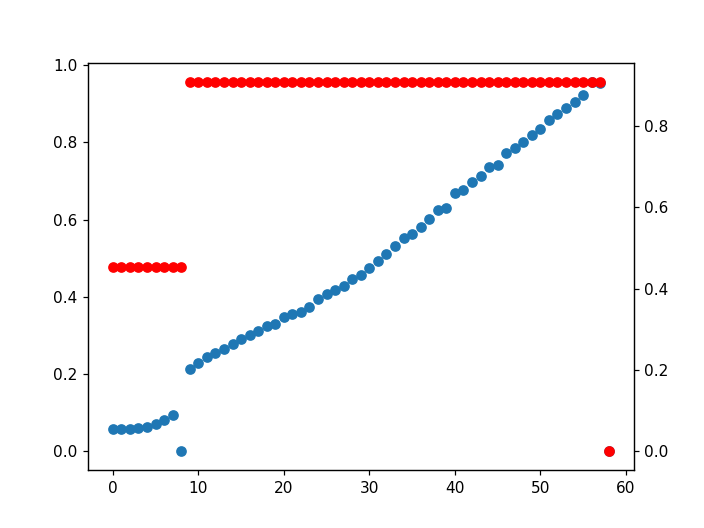

In [19]:
tpsz = 59
normalization_const = np.zeros(tpsz)
average_count= np.zeros(tpsz)
xvoxel = np.zeros(tpsz)
tpix = 0
for ix in range(len(max_count_ar)):
    for tsix in range(len(max_count_ar[ix])):
        normalization_const[tpix] = np.max(max_count_ar[ix][tsix])
        average_count[tpix] = np.max(average_count_ar[ix][tsix])
        xvoxel[tpix] = dim_desc_ar[ix]["xvoxel"]
        tpix = tpix+1
fig,ax = plt.subplots()
ax.plot(average_count, 'o')

ax2 = ax.twinx()
ax2.plot(xvoxel, 'ro')

In [22]:
df = pd.DataFrame({"max_filtered_counts": normalization_const,
                   "average_counts": average_count})
df.index = np.arange(1,60)
df.index.name = "Tp_id"
df

,max_filtered_counts,average_counts
Tp_id,,
1,8.0,0.056830
2,7.0,0.057373
3,9.0,0.059159
4,8.0,0.060877
5,10.0,0.064520
6,10.0,0.071765
7,10.0,0.081134
8,12.0,0.094280
9,0.0,0.000000


In [24]:
df.to_csv(exp_folder + f"{exp_name}_filtered_counts.csv")

In [ ]:
ix = 5
image = acq_df["image_xml"][ix]
acq_name = acq_df["acq_name"][ix]
acq_type = acq_df["acq_type"][ix]
base_folder = acq_df["base_folder"][ix]
print("Running for '%s', using method '%s'" % (acq_name, acq_type))
base_folder

In [ ]:
# merged_path = merged_folder + f"{acq_name}_t0_z000.tif"
if acq_type == "xyzt":
    boxfiltered_path = base_folder + channel_str + "/Boxfiltered/" + acq_name + "_Boxfiltered_t00_z000_" + channel_str + ".tif"
elif acq_type == "xyz":
    boxfiltered_path = base_folder + channel_str + "/Boxfiltered/" + acq_name + "_Boxfiltered_z00_" + channel_str + ".tif"
else:
    print("Not yet defined!!")
    
# Image dimension description
dim_desc = cm.collectImageDim(image)

img_test = cv2.imread(boxfiltered_path)
(height, width, layers) = img_test.shape

print("Image shape: (h%d,w%d,l%d)" % (height, width, layers))

In [ ]:
# Copy all .tif file into a list
fname_list = glob.glob(base_folder+f"{channel_str}/TileScan/*.tif")
# For each file, collect string identifierse for t,s and z
tstr_st, sstr_st, zstr_st = set(),set(),set()
tstr_ix = 11     # timepoint identifier index
sstr_ix = 12     # stagepos identifier index
zstr_ix = 13    # z-scan identifier index

print("Did you check the tstr_ix, sstr_ix and zstr_ix??")
display(fname_list[0].split("_"))
display(fname_list[0].split("_")[zstr_ix])

In [ ]:
for fname in fname_list:
    fname_splt = fname.split("_")
    if tstr_ix is not None:
        tstr_st.add(fname_splt[tstr_ix])
    if sstr_ix is not None:
        sstr_st.add(fname_splt[sstr_ix])
    if zstr_ix is not None:
        zstr_st.add(fname_splt[zstr_ix])
    
# Sort the string identifiers and save as an array
tstr_ar = np.sort(list(tstr_st))
sstr_ar = np.sort(list(sstr_st))
zstr_ar = np.sort(list(zstr_st))

In [ ]:
# Let's test merging a single timepoint for each z sections
# tstr = fname_list[-1].split("_")[tstr_ix]   # Last timepoint
if acq_type == "xyzt":
    print("Do nothing. The rest is designed for xyzt")
#     tstr_ar = ["t10"]
elif acq_type == "xyz":
    tstr_ar = [None]

# zstr_ar = ["z160"]

# Run through all the tstr and zstr
fname_test = fname_list[0]
img_test = cv2.imread(fname_test, cv2.IMREAD_GRAYSCALE)
height, width = img_test.shape

# For each timepoint
average_count_ar = np.zeros(len(zstr_ar))
max_count_ar = np.zeros(len(zstr_ar))
for tix in range(len(tstr_ar)):
    tstr = tstr_ar[tix]
    # For each z section
    for zix in range(len(zstr_ar)):
        zstr = zstr_ar[zix]
        # File path to merge into
        if tstr is not None:
            boxfiltered_path = base_folder + channel_str + "/Boxfiltered/" + acq_name + "_" + "Boxfiltered" + "_" + tstr + "_" + zstr + "_" + channel_str + ".tif"
        else:
            boxfiltered_path = base_folder + channel_str + "/Boxfiltered/" + acq_name + "_" + "Boxfiltered" + "_" + zstr + "_" + channel_str + ".tif"
        
        print(boxfiltered_path, end="    \r", flush=True)
        
        # Read the box-filtered image
        filtered = cv2.imread(boxfiltered_path, cv2.IMREAD_GRAYSCALE)
        
        # Collect the average values at each 50x50 corner for finding the surface
#         average_count_ar[zix] = np.mean(filtered[:50,:50] +
#                                 filtered[:50,-50:] +
#                                 filtered[-50:,-50:] +
#                                 filtered[-50:, :50])/4
        average_count_ar[zix] = np.mean(filtered)
        max_count_ar[zix] = np.max(filtered)
    
# img_blur = cv2.GaussianBlur(img_merged_bw, (11,11),0)

# # Add contrast for better visualization.
# # alpha = 20
# # beta = -10
# # img_contrast = np.uint8(np.clip(alpha*img_merged_bw + beta, 0, 255))
# # Resize for video output
# img_resized = cv2.resize(img_merged_bw, (512,512))

# fig,ax = plt.subplots()

# ax.imshow(img_resized)

In [ ]:
plt.plot(average_count_ar)